In [1]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd
from os import listdir
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l1,l2
import keras.backend as K
K.set_image_dim_ordering('tf')
import regex as re

dName = re.compile('_[A-Za-z0-9]*.mat')

tWindow = 25

def prepareData(data, tags):
    currFrame = 0
    retData = []
    retTags = []
    for index, row in tags.iterrows():
        start = (int(int(row[0])*25))
        stop = (int(int(row[1])*25))
        if(start != stop):
            retData.append(data[start:stop])
            retTags.append(1 if row[2] not in ["(nothing)", "multiple_actions"] else 0)
            currFrame = stop - 1
        else:
            if(start == currFrame):
                retTags[-1] = int(retTags[-1] or (1 if row[2] not in ["(nothing)", "multiple_actions"] else 0))
            else:
                retData.append(np.array([data[start]]))
                retTags.append(1 if row[2] not in ["(nothing)", "multiple_actions"] else 0)
                currFrame = stop
    return np.array(retData), np.array(retTags)

def flattenData(data, tags):
    residue = []
    retData = []
    retTags = []
    index = 0
    lastTag = 0
    for item in data:
        if(len(residue) > 0):
            item = np.concatenate((residue, item), axis = 0)
        if(len(item) >= tWindow):
            i = 0
            while(len(item) > i+tWindow):
                retData.append(item[i:i+tWindow])
                retTags.append(1 if ((len(residue) > 0 and lastTag == 1) or tags[index] == 1) else 0)
                i += tWindow
            if(len(item)%tWindow != 0):
                residue = item[i:len(item)]
            lastTag = tags[index]
        else:
            residue = item
            lastTag = 1 if (lastTag == 1 or tags[index] == 1) else 0
        index += 1
    if(len(residue) > 0):
        retData.append(np.concatenate((residue, np.zeros((tWindow-len(residue), 22))), axis = 0))
        retTags.append(1 if ((len(residue) > 0 and lastTag == 1) or tags[index-1] == 1) else 0)
    return np.array(retData), np.array(retTags)
        

Using TensorFlow backend.


In [2]:
dataPath = "./Datasets/VSD_2014_December_official_release/Hollywood-dev/features/"
annotationsPath = "./Datasets/VSD_2014_December_official_release/Hollywood-dev/annotations/"

data_names = listdir(annotationsPath)

uDataNames = set()

for fname in data_names:
    if ("screams" in fname):
        uDataNames.add(fname.replace('_screams.txt', ''))
        
uDataNames = list(uDataNames)

In [3]:
model = Sequential()
model.add(Conv1D(64, 6, activation='relu', input_shape=(tWindow, 22), kernel_initializer='uniform',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D())
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 2, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(3000, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 64)            8512      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 256)            49408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 256)            1024      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 256)            196864    
_________________________________________________________________
max_pooling1d_2 (MaxP

In [4]:
results = dict()
i = 0
for movie in uDataNames:
    print(movie)
    epVal = 25
    if(movie in ["BillyElliot", "MidnightExpress", "SavingPrivateRyan", "Armageddon", "TheWickerMan", "TheWizardOfOz", "TheSixthSense", "Eragon"]):
        epVal = 60
    trainDataFile = h5py.File(dataPath + movie +"_auditory.mat")
    trainTags = pd.read_csv(annotationsPath + movie + "_screams.txt", sep = " ", header = None)

    trainData, trainTags = prepareData(np.array(trainDataFile.get("MFCC")), trainTags)
    ftrainData, ftrainTags = flattenData(trainData, trainTags)
    ftrainData = ftrainData.astype('float32')/3250
    
    results[movie] = model.fit(ftrainData, ftrainTags, epochs = epVal, validation_split = 0.2)
    i += 1
    print("Training advancement: ", int(float(i)/len(uDataNames)*100), "%")


ReservoirDogs
Instructions for updating:
Use tf.cast instead.
Train on 4568 samples, validate on 1142 samples
Epoch 1/25
4568/4568 [==============================] - 8s 2ms/step - loss: 0.4380 - acc: 0.8581 - val_loss: 0.6315 - val_acc: 0.7802
Epoch 2/25
4568/4568 [==============================] - 3s 618us/step - loss: 0.4054 - acc: 0.8608 - val_loss: 0.5812 - val_acc: 0.7802
Epoch 3/25
4568/4568 [==============================] - 3s 620us/step - loss: 0.4032 - acc: 0.8608 - val_loss: 0.6389 - val_acc: 0.7802
Epoch 4/25
4568/4568 [==============================] - 3s 612us/step - loss: 0.4018 - acc: 0.8608 - val_loss: 0.6799 - val_acc: 0.7802
Epoch 5/25
4568/4568 [==============================] - 3s 617us/step - loss: 0.4012 - acc: 0.8608 - val_loss: 0.5839 - val_acc: 0.7802
Epoch 6/25
4568/4568 [==============================] - 3s 618us/step - loss: 0.3996 - acc: 0.8608 - val_loss: 0.6065 - val_acc: 0.7802
Epoch 7/25
4568/4568 [==============================] - 3s 623us/step - loss

4780/4780 [==============================] - 3s 625us/step - loss: 0.5022 - acc: 0.7818 - val_loss: 1.6183 - val_acc: 0.4916
Epoch 33/60
4780/4780 [==============================] - 3s 621us/step - loss: 0.5009 - acc: 0.7818 - val_loss: 0.7612 - val_acc: 0.5326
Epoch 34/60
4780/4780 [==============================] - 3s 619us/step - loss: 0.4972 - acc: 0.7862 - val_loss: 0.8063 - val_acc: 0.5644
Epoch 35/60
4780/4780 [==============================] - 3s 619us/step - loss: 0.4930 - acc: 0.7885 - val_loss: 0.9624 - val_acc: 0.5209
Epoch 36/60
4780/4780 [==============================] - 3s 626us/step - loss: 0.4959 - acc: 0.7847 - val_loss: 0.7766 - val_acc: 0.5510
Epoch 37/60
4780/4780 [==============================] - 3s 647us/step - loss: 0.4857 - acc: 0.7923 - val_loss: 0.7952 - val_acc: 0.5226
Epoch 38/60
4780/4780 [==============================] - 3s 629us/step - loss: 0.4814 - acc: 0.7954 - val_loss: 1.1469 - val_acc: 0.4875
Epoch 39/60
4780/4780 [==============================

5076/5076 [==============================] - 3s 626us/step - loss: 0.2164 - acc: 0.9240 - val_loss: 1.8435 - val_acc: 0.6276
Epoch 32/60
5076/5076 [==============================] - 3s 625us/step - loss: 0.2136 - acc: 0.9263 - val_loss: 1.0957 - val_acc: 0.6866
Epoch 33/60
5076/5076 [==============================] - 3s 626us/step - loss: 0.2064 - acc: 0.9255 - val_loss: 1.5245 - val_acc: 0.6252
Epoch 34/60
5076/5076 [==============================] - 3s 626us/step - loss: 0.1982 - acc: 0.9346 - val_loss: 1.7415 - val_acc: 0.5535
Epoch 35/60
5076/5076 [==============================] - 3s 640us/step - loss: 0.1890 - acc: 0.9385 - val_loss: 2.1173 - val_acc: 0.65040.1804
Epoch 36/60
5076/5076 [==============================] - 3s 629us/step - loss: 0.1914 - acc: 0.9350 - val_loss: 2.0351 - val_acc: 0.5882
Epoch 37/60
5076/5076 [==============================] - 3s 620us/step - loss: 0.1871 - acc: 0.9340 - val_loss: 1.6476 - val_acc: 0.6724
Epoch 38/60
5076/5076 [========================

4476/4476 [==============================] - 3s 611us/step - loss: 0.4317 - acc: 0.8152 - val_loss: 1.3514 - val_acc: 0.4727
Epoch 5/25
4476/4476 [==============================] - 3s 616us/step - loss: 0.3930 - acc: 0.8374 - val_loss: 4.3291 - val_acc: 0.3003
Epoch 6/25
4476/4476 [==============================] - 3s 612us/step - loss: 0.3628 - acc: 0.8537 - val_loss: 2.1907 - val_acc: 0.4817
Epoch 7/25
4476/4476 [==============================] - 3s 613us/step - loss: 0.3357 - acc: 0.8677 - val_loss: 3.4725 - val_acc: 0.4138
Epoch 8/25
4476/4476 [==============================] - 3s 613us/step - loss: 0.3072 - acc: 0.8814 - val_loss: 4.4027 - val_acc: 0.3727
Epoch 9/25
4476/4476 [==============================] - 3s 614us/step - loss: 0.2860 - acc: 0.8948 - val_loss: 3.4082 - val_acc: 0.4066
Epoch 10/25
4476/4476 [==============================] - 3s 613us/step - loss: 0.2565 - acc: 0.9062 - val_loss: 4.7313 - val_acc: 0.3601
Epoch 11/25
4476/4476 [==============================] - 3

4939/4939 [==============================] - 3s 617us/step - loss: 0.4621 - acc: 0.7779 - val_loss: 7.7467 - val_acc: 0.2356
Epoch 13/60
4939/4939 [==============================] - 3s 615us/step - loss: 0.4464 - acc: 0.7821 - val_loss: 1.8774 - val_acc: 0.5652
Epoch 14/60
4939/4939 [==============================] - 3s 614us/step - loss: 0.4320 - acc: 0.7882 - val_loss: 0.9657 - val_acc: 0.8130
Epoch 15/60
4939/4939 [==============================] - 3s 612us/step - loss: 0.4208 - acc: 0.7996 - val_loss: 1.7305 - val_acc: 0.4713
Epoch 16/60
4939/4939 [==============================] - 3s 615us/step - loss: 0.4076 - acc: 0.8042 - val_loss: 2.8002 - val_acc: 0.3312
Epoch 17/60
4939/4939 [==============================] - 3s 615us/step - loss: 0.3852 - acc: 0.8194 - val_loss: 12.2294 - val_acc: 0.1174
Epoch 18/60
4939/4939 [==============================] - 3s 614us/step - loss: 0.3805 - acc: 0.8245 - val_loss: 2.9584 - val_acc: 0.3717
Epoch 19/60
4939/4939 [=============================

6396/6396 [==============================] - 4s 610us/step - loss: 0.3952 - acc: 0.8258 - val_loss: 0.6568 - val_acc: 0.9575
Epoch 12/25
6396/6396 [==============================] - 4s 611us/step - loss: 0.3709 - acc: 0.8336 - val_loss: 1.0066 - val_acc: 0.7661
Epoch 13/25
6396/6396 [==============================] - 4s 611us/step - loss: 0.3603 - acc: 0.8455 - val_loss: 0.7544 - val_acc: 0.7511
Epoch 14/25
6396/6396 [==============================] - 4s 616us/step - loss: 0.3250 - acc: 0.8679 - val_loss: 0.6027 - val_acc: 0.9400
Epoch 15/25
6396/6396 [==============================] - 4s 618us/step - loss: 0.3204 - acc: 0.8674 - val_loss: 0.5526 - val_acc: 0.9362
Epoch 16/25
6396/6396 [==============================] - 4s 614us/step - loss: 0.3015 - acc: 0.8779 - val_loss: 0.7728 - val_acc: 0.8049
Epoch 17/25
6396/6396 [==============================] - 4s 610us/step - loss: 0.3418 - acc: 0.8576 - val_loss: 0.6733 - val_acc: 0.9575
Epoch 18/25
6396/6396 [==============================

4693/4693 [==============================] - 3s 610us/step - loss: 0.2468 - acc: 0.9103 - val_loss: 3.1237 - val_acc: 0.4600
Epoch 46/60
4693/4693 [==============================] - 3s 614us/step - loss: 0.2239 - acc: 0.9150 - val_loss: 3.1929 - val_acc: 0.5162
Epoch 47/60
4693/4693 [==============================] - 3s 613us/step - loss: 0.2405 - acc: 0.9154 - val_loss: 2.4744 - val_acc: 0.5264
Epoch 48/60
4693/4693 [==============================] - 3s 613us/step - loss: 0.2240 - acc: 0.9177 - val_loss: 2.3457 - val_acc: 0.5928
Epoch 49/60
4693/4693 [==============================] - 3s 616us/step - loss: 0.2189 - acc: 0.9214 - val_loss: 4.3223 - val_acc: 0.4881
Epoch 50/60
4693/4693 [==============================] - 3s 614us/step - loss: 0.2251 - acc: 0.9212 - val_loss: 3.4576 - val_acc: 0.4046
Epoch 51/60
4693/4693 [==============================] - 3s 611us/step - loss: 0.2024 - acc: 0.9316 - val_loss: 2.4105 - val_acc: 0.5656
Epoch 52/60
4693/4693 [==============================

4681/4681 [==============================] - 3s 626us/step - loss: 0.1974 - acc: 0.9346 - val_loss: 2.5968 - val_acc: 0.5457
Epoch 45/60
4681/4681 [==============================] - 3s 626us/step - loss: 0.1890 - acc: 0.9383 - val_loss: 2.0615 - val_acc: 0.8147
Epoch 46/60
4681/4681 [==============================] - 3s 627us/step - loss: 0.2009 - acc: 0.9331 - val_loss: 2.2089 - val_acc: 0.6003
Epoch 47/60
4681/4681 [==============================] - 3s 627us/step - loss: 0.1973 - acc: 0.9370 - val_loss: 1.1850 - val_acc: 0.7942
Epoch 48/60
4681/4681 [==============================] - 3s 626us/step - loss: 0.1806 - acc: 0.9387 - val_loss: 1.9477 - val_acc: 0.8138
Epoch 49/60
4681/4681 [==============================] - 3s 624us/step - loss: 0.1886 - acc: 0.9359 - val_loss: 1.3280 - val_acc: 0.8147
Epoch 50/60
4681/4681 [==============================] - 3s 628us/step - loss: 0.1845 - acc: 0.9417 - val_loss: 1.1894 - val_acc: 0.8010
Epoch 51/60
4681/4681 [==============================

7787/7787 [==============================] - 5s 612us/step - loss: 0.4325 - acc: 0.7891 - val_loss: 2.5744 - val_acc: 0.5860
Epoch 44/60
7787/7787 [==============================] - 5s 615us/step - loss: 0.4309 - acc: 0.7916 - val_loss: 3.0536 - val_acc: 0.6055
Epoch 45/60
7787/7787 [==============================] - 5s 615us/step - loss: 0.4272 - acc: 0.7944 - val_loss: 2.8059 - val_acc: 0.3534
Epoch 46/60
7787/7787 [==============================] - 5s 615us/step - loss: 0.4234 - acc: 0.7979 - val_loss: 2.3059 - val_acc: 0.4376
Epoch 47/60
7787/7787 [==============================] - 5s 616us/step - loss: 0.4079 - acc: 0.8078 - val_loss: 1.9796 - val_acc: 0.5244
Epoch 48/60
7787/7787 [==============================] - 5s 618us/step - loss: 0.3989 - acc: 0.8105 - val_loss: 3.3986 - val_acc: 0.5259
Epoch 49/60
7787/7787 [==============================] - 5s 620us/step - loss: 0.4006 - acc: 0.8105 - val_loss: 7.1625 - val_acc: 0.4525
Epoch 50/60
7787/7787 [==============================

Epoch 17/25
5075/5075 [==============================] - 3s 614us/step - loss: 0.5023 - acc: 0.7738 - val_loss: 0.5095 - val_acc: 0.8842
Epoch 18/25
5075/5075 [==============================] - 3s 616us/step - loss: 0.4985 - acc: 0.7762 - val_loss: 0.6179 - val_acc: 0.9110
Epoch 19/25
5075/5075 [==============================] - 3s 614us/step - loss: 0.4922 - acc: 0.7766 - val_loss: 0.4816 - val_acc: 0.9054
Epoch 20/25
5075/5075 [==============================] - 3s 614us/step - loss: 0.4928 - acc: 0.7762 - val_loss: 0.7896 - val_acc: 0.7920
Epoch 21/25
5075/5075 [==============================] - 3s 612us/step - loss: 0.4805 - acc: 0.7825 - val_loss: 4.9084 - val_acc: 0.2790
Epoch 22/25
5075/5075 [==============================] - 3s 616us/step - loss: 0.4759 - acc: 0.7813 - val_loss: 0.7623 - val_acc: 0.8645
Epoch 23/25
5075/5075 [==============================] - 3s 613us/step - loss: 0.4740 - acc: 0.7842 - val_loss: 0.6050 - val_acc: 0.8708
Epoch 24/25
5075/5075 [==================

5564/5564 [==============================] - 3s 615us/step - loss: 0.4251 - acc: 0.7933 - val_loss: 2.2276 - val_acc: 0.5517
Epoch 52/60
5564/5564 [==============================] - 3s 615us/step - loss: 0.4150 - acc: 0.8039 - val_loss: 4.6579 - val_acc: 0.5575
Epoch 53/60
5564/5564 [==============================] - 3s 613us/step - loss: 0.4098 - acc: 0.8034 - val_loss: 1.3522 - val_acc: 0.5726
Epoch 54/60
5564/5564 [==============================] - 3s 614us/step - loss: 0.4115 - acc: 0.8027 - val_loss: 3.3871 - val_acc: 0.5704
Epoch 55/60
5564/5564 [==============================] - 3s 615us/step - loss: 0.4038 - acc: 0.8066 - val_loss: 1.9800 - val_acc: 0.5855
Epoch 56/60
5564/5564 [==============================] - 3s 614us/step - loss: 0.4218 - acc: 0.8027 - val_loss: 6.4862 - val_acc: 0.5747
Epoch 57/60
5564/5564 [==============================] - 3s 616us/step - loss: 0.3992 - acc: 0.8088 - val_loss: 3.9897 - val_acc: 0.5144
Epoch 58/60
5564/5564 [==============================

6793/6793 [==============================] - 4s 615us/step - loss: 0.3774 - acc: 0.8406 - val_loss: 11.2221 - val_acc: 0.2301
Epoch 51/60
6793/6793 [==============================] - 4s 616us/step - loss: 0.3786 - acc: 0.8388 - val_loss: 1.1813 - val_acc: 0.6527
Epoch 52/60
6793/6793 [==============================] - 4s 616us/step - loss: 0.3756 - acc: 0.8373 - val_loss: 1.5982 - val_acc: 0.5903
Epoch 53/60
6793/6793 [==============================] - 4s 617us/step - loss: 0.3758 - acc: 0.8376 - val_loss: 1.2200 - val_acc: 0.7316
Epoch 54/60
6793/6793 [==============================] - 4s 616us/step - loss: 0.3719 - acc: 0.8438 - val_loss: 1.0629 - val_acc: 0.6727
Epoch 55/60
6793/6793 [==============================] - 4s 614us/step - loss: 0.3714 - acc: 0.8473 - val_loss: 1.2449 - val_acc: 0.6869
Epoch 56/60
6793/6793 [==============================] - 4s 615us/step - loss: 0.3645 - acc: 0.8470 - val_loss: 8.4213 - val_acc: 0.2295
Epoch 57/60
6793/6793 [=============================

5927/5927 [==============================] - 4s 615us/step - loss: 0.6378 - acc: 0.6086 - val_loss: 0.8307 - val_acc: 0.7794
Epoch 24/25
5927/5927 [==============================] - 4s 614us/step - loss: 0.6284 - acc: 0.6163 - val_loss: 0.9253 - val_acc: 0.4116
Epoch 25/25
5927/5927 [==============================] - 4s 615us/step - loss: 0.6285 - acc: 0.6189 - val_loss: 0.7749 - val_acc: 0.7375
Training advancement:  100 %


In [8]:
# serialize model to JSON
model_json = model.to_json()
with open("modelv4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelv4.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
testPath = "./Datasets/VSD_2014_December_official_release/YouTube-gen/features/"

test_names = listdir(testPath)

uTestNames = set()

for fname in test_names:
    uTestNames.add(fname.replace(dName.search(fname).group(), ''))
        
uTestNames = list(uTestNames)

YULESOhr7Rg


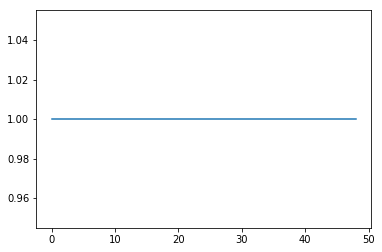

In [11]:
testName = uTestNames[rnd.randint(0, len(uTestNames) - 1)]
print(testName)
testDataFile = h5py.File(testPath + testName +"_auditory.mat")
testData = np.array(testDataFile.get("MFCC"))
result = []

i = 0
while(len(testData) > i+tWindow):
    prepare = testData[i:i+tWindow]
    prepare = prepare.astype('float32')/3250
    result.append(model.predict(np.expand_dims(testData[i:i+tWindow], axis = 0)))
    i += tWindow
    
if(len(testData)%tWindow != 0):
    residue = np.concatenate((testData[i:len(testData)], np.zeros(((tWindow-(len(testData)%tWindow)), 22))), axis = 0)
    result.append(model.predict(np.expand_dims(residue, axis = 0))[0])

plt.plot(result)